In [ ]:

!pip install tensorflow keras opencv-python matplotlib scikit-learn -q

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score




In [ ]:

from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API configured")


Saving kaggle.json to kaggle.json
✅ Kaggle API configured


In [ ]:

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force
!unzip -qo chest-xray-pneumonia.zip -d chest_xray

print("Dataset downloaded and extracted")



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:21<00:00, 36.1MB/s]
100% 2.29G/2.29G [00:21<00:00, 114MB/s] 
✅ Dataset downloaded and extracted


In [ ]:

base_dir = "chest_xray"
if os.path.exists(os.path.join(base_dir, "chest_xray")):
    base_dir = os.path.join(base_dir, "chest_xray")

train_path = os.path.join(base_dir, "train")
test_path  = os.path.join(base_dir, "test")
val_path   = os.path.join(base_dir, "val")

print("Train path:", train_path)
print("Test path:", test_path)
print("Val path:", val_path)

# Count images
print("Train images:", sum([len(files) for r, d, files in os.walk(train_path)]))
print("Test images:", sum([len(files) for r, d, files in os.walk(test_path)]))
print("Val images:", sum([len(files) for r, d, files in os.walk(val_path)]))


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:15<00:00, 349MB/s]
100% 2.29G/2.29G [00:15<00:00, 160MB/s]


In [ ]:
# Base extraction folder
base_dir = "chest_xray"

# Handle nested folder case
if os.path.exists(os.path.join(base_dir, "chest_xray")):
    base_dir = os.path.join(base_dir, "chest_xray")

# Define paths
train_path = os.path.join(base_dir, "train")
test_path  = os.path.join(base_dir, "test")
val_path   = os.path.join(base_dir, "val")

print("Train path:", train_path)
print("Test path:", test_path)
print("Val path:", val_path)

# Quick check: number of images
print("Train images:", sum([len(files) for r, d, files in os.walk(train_path)]))
print("Test images:", sum([len(files) for r, d, files in os.walk(test_path)]))
print("Val images:", sum([len(files) for r, d, files in os.walk(val_path)]))


Train path: chest_xray/chest_xray/train
Test path: chest_xray/chest_xray/test
Val path: chest_xray/chest_xray/val
Train images: 5216
Test images: 624
Val images: 16


In [ ]:

IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    subset="training",
    batch_size=BATCH_SIZE
)

val_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    subset="validation",
    batch_size=BATCH_SIZE
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history_cnn = model_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=2
)

print("Training complete")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 - 73s - 554ms/step - accuracy: 0.8138 - loss: 0.4287 - val_accuracy: 0.8802 - val_loss: 0.2628
Epoch 2/10
131/131 - 72s - 546ms/step - accuracy: 0.9092 - loss: 0.2329 - val_accuracy: 0.8965 - val_loss: 0.2621
Epoch 3/10
131/131 - 62s - 470ms/step - accuracy: 0.9236 - loss: 0.1934 - val_accuracy: 0.9243 - val_loss: 0.1794
Epoch 4/10
131/131 - 61s - 464ms/step - accuracy: 0.9295 - loss: 0.1822 - val_accuracy: 0.9271 - val_loss: 0.1732
Epoch 5/10
131/131 - 61s - 468ms/step - accuracy: 0.9401 - loss: 0.1567 - val_accuracy: 0.9080 - val_loss: 0.2295
Epoch 6/10
131/131 - 61s - 467ms/step - accuracy: 0.9382 - loss: 0.1639 - val_accuracy: 0.8830 - val_loss: 0.3298
Epoch 7/10
131/131 - 61s - 466ms/step - accuracy: 0.9391 - loss: 0.1747 - val_accuracy: 0.9415 - val_loss: 0.1483
Epoch 8/10
131/131 - 68s - 523ms/step - accuracy: 0.9434 - loss: 0.1564 - val_accuracy: 0.9291 - val_loss: 0.1625
Epoch 9/10
131/131 - 61s - 464ms/step - accuracy: 0.9502 - loss: 0.1329 - val_accuracy: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.7027 - loss: 0.9220
✅ Test Accuracy: 0.83
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step


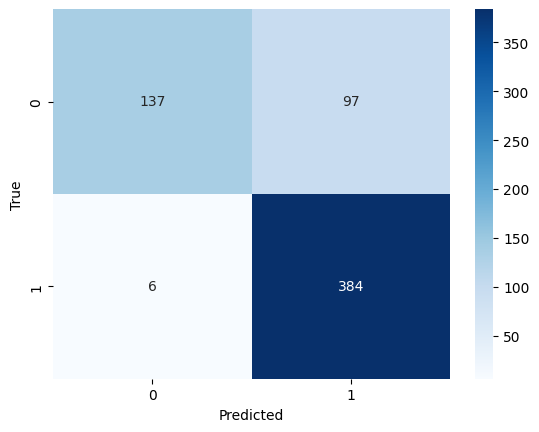

              precision    recall  f1-score   support

           0       0.96      0.59      0.73       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.79      0.80       624
weighted avg       0.86      0.83      0.82       624

ROC-AUC: 0.79


In [ ]:

loss, acc = model_cnn.evaluate(test_gen)
print(f"Test Accuracy: {acc:.2f}")

y_true = test_gen.classes
y_pred = (model_cnn.predict(test_gen) > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))

auc = roc_auc_score(y_true, y_pred)
print(f"ROC-AUC: {auc:.2f}")


In [ ]:

model_cnn.save("pneumonia_cnn_model.h5")
print("Model saved as pneumonia_cnn_model.h5")


✅ Model saved as pneumonia_cnn_model.h5
